In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import math

from scipy.stats import poisson
from scipy.stats import poisson
from scipy.stats import chisquare


from ortools.linear_solver import pywraplp

from scipy.spatial.distance import cdist

from tsp_solver.util import path_cost
import fast_tsp

import time

In [2]:
def montecarlo(df, n):  
    resultados = []
    for _ in range(n):
        num = np.random.rand()
        for j in range(len(df)):
            if df[j][3] <= num < df[j][4]:
                resultados.append(j)
            
    return resultados

## Clusterización

In [3]:
ds = pd.read_csv('distancias_tiempos2.csv')
ds = ds[['Distance', 'Duration']]

ds['Duration'] = pd.to_datetime(ds['Duration'])
ds['Duration'] = ds['Duration'].dt.strftime('%H:%M')
ds['Duration']=ds['Duration'].astype('string')

def convert_to_seconds(time_str):
    hours, minutes = map(int, time_str.split(':'))
    total_seconds = hours * 3600 + minutes * 60
    return total_seconds

# Apply the conversion function to the DataFrame column
ds['Segundos'] = ds['Duration'].apply(convert_to_seconds)
rangos = np.arange(0,40401,201)
cuadrada = []
for i in range(len(rangos)-1):
    cuadrada.append(list((ds['Segundos'][rangos[i]:rangos[i+1]])))
result_array = np.append(np.array(cuadrada), [(ds['Segundos'][rangos[-1]:])], axis = 0)
result_array.shape

(201, 201)

In [4]:
cuadrada = []
for i in range(len(rangos)-1):
    cuadrada.append(list((ds['Distance'][rangos[i]:rangos[i+1]])))
resulta_array = np.append(np.array(cuadrada), [(ds['Distance'][rangos[-1]:])], axis = 0)
resulta_array

array([[ 0.  , 15.26,  9.77, ..., 11.08,  9.65, 12.54],
       [15.51,  0.  , 21.01, ..., 17.01, 17.9 , 14.33],
       [ 9.01, 19.93,  0.  , ..., 18.61, 17.17, 20.07],
       ...,
       [ 9.9 , 17.47, 18.35, ...,  0.  ,  3.11,  2.25],
       [ 8.35, 16.18, 17.06, ...,  3.2 ,  0.  ,  5.26],
       [11.81, 13.71, 20.48, ...,  2.47,  5.58,  0.  ]])

In [5]:
def remove_first_row_and_column(input_array):
    if input_array.shape[0] <= 1 or input_array.shape[1] <= 1:
        raise ValueError("Input array must have at least 2 rows and 2 columns.")

    new_array = input_array[1:, 1:]
    return new_array

In [6]:
dm = pd.read_csv('lat_lon.csv')

In [7]:
dm = dm.rename(columns={'Latitude (y)': 'LAT', 'Longitude (x)': 'LON'})
coordenadas = [tuple(array) for array in dm.to_numpy()]

In [8]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
from ipywidgets import interactive
from collections import defaultdict
import folium
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10
sns.set(style="white")

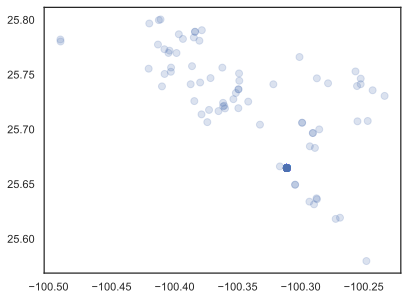

In [9]:
X = np.array(dm[["LON", "LAT"]], dtype="float64")
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


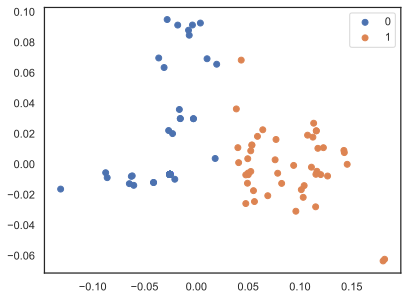

In [10]:
#Importing required modules
 
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
 
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(dm[["LON", "LAT"]])
 
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 2)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

dm["CLUSTER"] = label

In [11]:
m = folium.Map(location=[dm.LAT.mean(), dm.LON.mean()], zoom_start=9, 
               tiles='OpenStreet Map')

x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lon, cluster in zip(dm["LAT"], dm["LON"],dm["CLUSTER"]):
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(m)

m

In [12]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

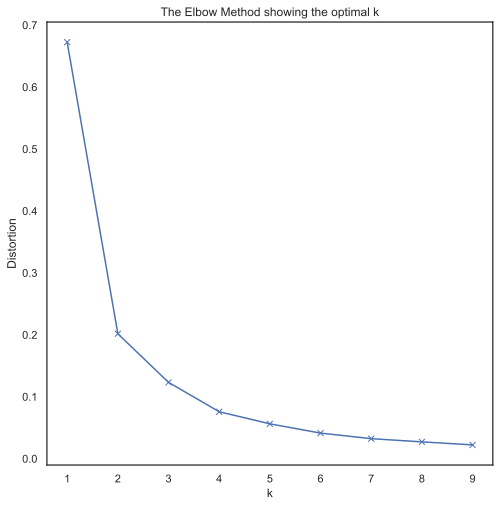

In [13]:
plt.figure(figsize=(8,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [14]:
labels = label

In [15]:
clusters = {}
my_list = np.array(labels)
for i in range(0,2): 
    indices = np.where(my_list == i)[0]
    #indices = np.add(1, indices)
    clusters.update({i:indices})

## Generación de pedidos

In [16]:
compras = pd.read_excel('informacion_compra.xlsx')
compras.head(3)

,Producto,Unidades,Factura
0,48443,1,799186
1,42877,1,717106
2,48296,1,468125


In [17]:
facturas = []
productos = []
for _,i in compras.iterrows():
    facturas += [i[2]]*i[1]
for _,i in compras.iterrows():
    productos += [i[0]]*i[1]

compras = pd.DataFrame({
    "Factura": facturas,
    "Producto": productos
})

In [18]:
df = compras.groupby(['Factura']).size().reset_index(name='Frequency').Frequency.value_counts()
df = df.reset_index()
df.columns = ['Pedidos', 'Frecuencia']
df['Frecuencia ln'] = np.log(df['Frecuencia'])
valor_medio = np.sum(df['Pedidos'] * df['Frecuencia ln']) / np.sum(df['Frecuencia ln'])
df['Poisson'] = poisson.pmf(df['Pedidos'], valor_medio)
df['valores_esperados'] = df['Poisson'] * np.sum(df['Frecuencia ln'])
df.head(3)

,Pedidos,Frecuencia,Frecuencia ln,Poisson,valores_esperados
0,1,19235,9.864487,0.011672,0.783311
1,2,3546,8.173575,0.036706,2.463277
2,3,1024,6.931472,0.076953,5.164178


In [19]:
df2 = compras.groupby(['Producto']).size().reset_index(name='Frequency').Frequency.value_counts()
df2 = df2.reset_index()
df2.columns = ['Producto', 'Frecuencia']
df2['Frecuencia ln'] = np.log(df2['Frecuencia'])
valor_medio = np.sum(df2['Producto'] * df2['Frecuencia ln']) / np.sum(df2['Frecuencia ln'])
df2['Poisson'] = poisson.pmf(df2['Producto'], valor_medio)
df2['valores_esperados'] = df2['Poisson'] * np.sum(df2['Frecuencia ln'])
df2.head(3)

,Producto,Frecuencia,Frecuencia ln,Poisson,valores_esperados
0,1,1793,7.491645,1.565792e-11,2.886239e-09
1,2,779,6.658011,2.209339e-10,4.072494e-08
2,3,414,6.025866,2.078257e-09,3.830870e-07


In [20]:
pedidos = df[['Pedidos','Poisson']]
pedidos['Acumulado'] = pedidos.Poisson.cumsum()
pedidos['Inferior'] = [0] + pedidos['Acumulado'].tolist()[:-1]
pedidos['Superior'] = pedidos['Acumulado']
pedidos = pedidos.to_numpy()

C:\Users\gerar\AppData\Local\Temp\ipykernel_33600\3932492861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedidos['Acumulado'] = pedidos.Poisson.cumsum()
C:\Users\gerar\AppData\Local\Temp\ipykernel_33600\3932492861.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pedidos['Inferior'] = [0] + pedidos['Acumulado'].tolist()[:-1]


In [21]:
producto = df2[['Producto','Poisson']]
producto['Acumulado'] = producto.Poisson.cumsum()
producto['Inferior'] = [0] + producto['Acumulado'].tolist()[:-1]
producto['Superior'] = producto['Acumulado']
producto = producto.to_numpy()

C:\Users\gerar\AppData\Local\Temp\ipykernel_33600\3891866760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  producto['Acumulado'] = producto.Poisson.cumsum()
C:\Users\gerar\AppData\Local\Temp\ipykernel_33600\3891866760.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  producto['Inferior'] = [0] + producto['Acumulado'].tolist()[:-1]


In [22]:
dp = pd.read_csv('info_productos.csv')
dp.columns = ['Producto', 'Volumen']
nuevo_registro = {"Producto": 0, "Volumen": 0}
dp = pd.concat([pd.DataFrame([nuevo_registro]), dp], ignore_index=True)
VOLU = dp.to_numpy()[:,1]

In [23]:
from ortools.linear_solver import pywraplp
def create_data_model():
    """Create the data for the example."""
    data = {}
    weights = dimensiones
    data["weights"] = weights
    data["items"] = list(range(len(weights)))
    data["bins"] = data["items"]
    data["bin_capacity"] = 27 #isuzu aprox
    return data

def main():
    data = create_data_model()

    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver("SCIP")

    if not solver:
        return

    # Variables
    # x[i, j] = 1 if item i is packed in bin j.
    x = {}
    for i in data["items"]:
        for j in data["bins"]:
            x[(i, j)] = solver.IntVar(0, 1, "x_%i_%i" % (i, j))

    # y[j] = 1 if bin j is used.
    y = {}
    for j in data["bins"]:
        y[j] = solver.IntVar(0, 1, "y[%i]" % j)

    # Constraints
    # Each item must be in exactly one bin.
    for i in data["items"]:
        solver.Add(sum(x[i, j] for j in data["bins"]) == 1)

    # The amount packed in each bin cannot exceed its capacity.
    for j in data["bins"]:
        solver.Add(
            sum(x[(i, j)] * data["weights"][i] for i in data["items"])
            <= y[j] * data["bin_capacity"]
        )

    # Objective: minimize the number of bins used.
    solver.Minimize(solver.Sum([y[j] for j in data["bins"]]))

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        num_bins = 0
        for j in data["bins"]:
            if y[j].solution_value() == 1:
                bin_items = []
                bin_weight = 0
                for i in data["items"]:
                    if x[i, j].solution_value() > 0:
                        bin_items.append(i)
                        bin_weight += data["weights"][i]
                if bin_items:
                    num_bins += 1
                    '''print("Camión # ", j+1)
                    print("Cantidad de clientes # ", len(bin_items))
                    print("  Clientes:", bin_items)
                    print(f"  Volumen total (m^3): {round(bin_weight, 2)}")
                    print()'''
        '''print()
        print("Cantidad de camiones:", num_bins)
        print("Capacidad de los camiones:", data["bin_capacity"], "m^3")
        print("Tiempo = ", solver.WallTime(), " milisegundos")'''
    else:
        print("No existe solución óptima.")


In [24]:
camiones_prom = []
turnos_prom = []
for i in range(10):
    cuadrada = []
    for i in range(len(rangos)-1):
        cuadrada.append(list((ds['Distance'][rangos[i]:rangos[i+1]])))
    resulta_array = np.append(np.array(cuadrada), [(ds['Distance'][rangos[-1]:])], axis = 0)
    random_indexes = np.random.choice(len(labels), np.random.choice((100,150)), replace=False)
    new_array = [labels[i] for i in random_indexes]
    
    new_clus = {'0': [], '1': []}
    for value, index in zip(new_array, random_indexes):
        new_clus[str(value)].append(index)
    resulta_array = resulta_array[random_indexes][:, random_indexes]
    num_pedidos = montecarlo(pedidos,compras.size)
    envios = [np.array(montecarlo(producto, num)) for num in montecarlo(pedidos,200) if num!=0]
    envios_np = envios[:len(random_indexes)]
    enviosArreglo = np.array([[-1,-1,-1]])
    for i in range(len(envios)):
        a = np.unique(np.array(envios[i]), return_counts=True)
        enviosArreglo = np.concatenate((enviosArreglo, np.array([np.array([i]*len(a[0])),a[0],a[1]]).T))

    dimensiones = []
    for pedido in envios_np:
        acumulado = 0
        for i in pedido:
            acumulado += VOLU[i]
        dimensiones.append(round(acumulado,4))
    
    if __name__ == "__main__":
        main()
    
    vol_por_clus = {0: [], 1: []}
    for value, index in zip(new_array, dimensiones):
        vol_por_clus[int(value)].append(index)

    multiplier = 1
    trucks_used = 0
    start_time=time.time()
    chamions = []
    for clave, volumenes in vol_por_clus.items():

        #print(f"**********CLUSTER # {clave + 1 }**********\n")
        incomplete = True
        while incomplete:
            data = {}
            data["weights"] = volumenes
            #data["values"] = len(data["weights"]) * [1]
            data["values"] =  volumenes
            sum_of_all_weights = sum(data["weights"])

            assert len(data["weights"]) == len(data["values"])
            data["num_items"] = len(data["weights"])
            data["all_items"] = range(data["num_items"])

            data["bin_capacities"] = [27] * multiplier
            data["num_bins"] = len(data["bin_capacities"])
            data["all_bins"] = range(data["num_bins"])

            solver = pywraplp.Solver.CreateSolver("SCIP")

            # x[i, b] = 1 if item i is packed in bin b.
            x = {}
            for i in data["all_items"]:
                for b in data["all_bins"]:
                    x[i, b] = solver.BoolVar(f"x_{i}_{b}")

            # Each item is assigned to at most one bin.
            for i in data["all_items"]:
                solver.Add(sum(x[i, b] for b in data["all_bins"]) <= 1)

            # The amount packed in each bin cannot exceed its capacity.
            for b in data["all_bins"]:
                solver.Add(
                    sum(x[i, b] * data["weights"][i] for i in data["all_items"])
                    <= data["bin_capacities"][b])

            # Each bin must contain at least 2 items
            for b in data["all_bins"]:
                solver.Add(sum(x[i, b] for i in data["all_items"]) <= 20)

             # Each bin must contain at most 20 items
            '''for b in data["all_bins"]:
                solver.Add(sum(x[i, b] for i in data["all_items"]) <= 20)'''

            # Maximize total value of packed items.
            objective = solver.Objective()
            for i in data["all_items"]:
                for b in data["all_bins"]:
                    objective.SetCoefficient(x[i, b], data["values"][i])
            objective.SetMaximization()

            start_time=time.time()
            status = solver.Solve()

            if status == pywraplp.Solver.OPTIMAL:

                unused_items = [i for i in data["all_items"] if all(x[i, b].solution_value() == 0 for b in data["all_bins"])]


                used_bins = [b for b in data["all_bins"] if any(x[i, b].solution_value() > 0 for i in data["all_items"])]
                if len(unused_items) != 0:
                    multiplier += 1

                if len(unused_items) == 0:

                    '''print(f"Número de camiones requeridos: {len(used_bins)}\n")

                    print(f"Valor total empaquetado: {round(objective.Value(), 2)}\n")'''

                    max_value_bin = None
                    max_value = 0
                    total_weight = 0
                    total_value = 0
                    for b in used_bins:
                        '''print(f"*** CAMIÓN # {b+1} ***")
                        print(f'Capacidad: {data["bin_capacities"][b]}')'''
                        bin_weight = 0
                        bin_value = 0
                        packed_items = []
                        for i in data["all_items"]:
                            if x[i, b].solution_value() > 0:
                                packed_items.append(str(clusters[clave][i]))
                                bin_weight += data["weights"][i]
                                bin_value += data["values"][i]
                        '''print(f"Clientes empacados: {', '.join(packed_items)}")
                        print(f"Volumen empaquetado en el camión: {round(bin_weight, 4)}\n")'''
                        #print(f"Valor empaquetado del camión: {bin_value}\n")
                        total_value += bin_value
                        total_weight += bin_weight
                        if bin_value > max_value:
                            max_value = bin_value
                            max_value_bin = b
                        chamions.append([int(x) for x in packed_items])

                    trucks_used += len(used_bins)
                    incomplete = False

                # Print solution for the new bin (if exists)

            else:
                print("No existe solución óptima.")

    end_time=time.time()-start_time

    print(f"Camiones totales usados: {trucks_used}")
    camiones_prom.append(trucks_used)
    print(f"{end_time} segundos")

    my_dict = dict(zip(range(trucks_used), chamions))
    mini_tcps = []
    for i in my_dict:
        i = list(my_dict[i]) + [0]
        mini_tcps.append(result_array[i,:][:,i])

    Turno = 0
    turnos = [1]
    ordenTSP = []

    tsp = len(mini_tcps)
    i = 0
    while True:
        if  Turno <= 28800 and i < len(mini_tcps):
            tour = fast_tsp.find_tour(mini_tcps[i], duration_seconds=0.01)
            Turno = Turno + path_cost(mini_tcps[i], tour)
            i = i+1
        elif i < tsp:
            i = i-1
            Turno = 0
            turnos.append(1)
        else:
            break
    print(f'Se ocupan {len(turnos)} turnos')
    turnos_prom.append(len(turnos))

print()
print(f'Camiones promedio: {np.mean(camiones_prom)}')
print(f'Desviación estándar: {np.std(camiones_prom)}')
print()
print(f'Turnos promedio: {np.mean(turnos_prom)}')
print(f'Desviación estándar: {np.std(turnos_prom)}')


    

Camiones totales usados: 5
0.0020401477813720703 segundos
Se ocupan 2 turnos
Camiones totales usados: 6
0.0059812068939208984 segundos
Se ocupan 3 turnos
Camiones totales usados: 6
0.0020258426666259766 segundos
Se ocupan 2 turnos
Camiones totales usados: 6
0.001950979232788086 segundos
Se ocupan 2 turnos
Camiones totales usados: 8
0.00951695442199707 segundos
Se ocupan 4 turnos
Camiones totales usados: 6
0.004985809326171875 segundos
Se ocupan 3 turnos
Camiones totales usados: 9
0.012222528457641602 segundos
Se ocupan 4 turnos
Camiones totales usados: 6
0.005568742752075195 segundos
Se ocupan 3 turnos
Camiones totales usados: 6
0.0040187835693359375 segundos
Se ocupan 3 turnos
Camiones totales usados: 8
0.013190507888793945 segundos
Se ocupan 4 turnos

Camiones promedio: 6.6
Desviación estándar: 1.2

Turnos promedio: 3.0
Desviación estándar: 0.7745966692414834


## Hasta aqui


In [25]:
# Generate 100 random indexes
random_indexes = np.random.choice(len(labels), np.random.choice((100,150)), replace=False)

# Create a new array from the selected indexes
new_array = [labels[i] for i in random_indexes]

# The 'random_indexes' variable now contains the indexes that were used
print("Selected indexes:", random_indexes)

# The 'new_array' contains the values from the original array at the selected indexes
print("New array:", new_array)


Selected indexes: [ 49  55  11 151  42  36 194 143 186  53 146  54  92 104 195 150 182  28
 173 184   7 192 155  31  72  20  58 108 153 144  62  45  61  73 164  82
  18 102  87 200 114 163 189 177 120 190 112 119 122  27  25 160 137   8
  44  41 167 101 181  85  24  34  39  90   2   1  88  99 154  91  16 175
  12 193  97 165  65  75 176   6 125  40  21 145 174 185 117   4 148 162
  67  68  23 188  64  94  50   3  30 140]
New array: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]


In [26]:
new_clus = {'0': [], '1': []}

for value, index in zip(new_array, random_indexes):
    new_clus[str(value)].append(index)

In [27]:
len(new_array)

100

In [28]:
len(dimensiones)

150

In [29]:
resulta_array = resulta_array[random_indexes][:, random_indexes]

IndexError: index 151 is out of bounds for axis 0 with size 150

In [ ]:
num_pedidos = montecarlo(pedidos,compras.size)
envios = [np.array(montecarlo(producto, num)) for num in montecarlo(pedidos,350) if num!=0]
envios_np = envios[:len(random_indexes)]
enviosArreglo = np.array([[-1,-1,-1]])
for i in range(len(envios)):
    a = np.unique(np.array(envios[i]), return_counts=True)
    enviosArreglo = np.concatenate((enviosArreglo, np.array([np.array([i]*len(a[0])),a[0],a[1]]).T))
enviosArreglo

In [ ]:
dp = pd.read_csv('info_productos.csv')
dp.columns = ['Producto', 'Volumen']
nuevo_registro = {"Producto": 0, "Volumen": 0}
dp = pd.concat([pd.DataFrame([nuevo_registro]), dp], ignore_index=True)
VOLU = dp.to_numpy()[:,1]

In [ ]:
np.random.randint(100)

In [ ]:
dimensiones = []
for pedido in envios_np:
    acumulado = 0
    for i in pedido:
        acumulado += VOLU[i]
    dimensiones.append(round(acumulado,4))

In [ ]:
from ortools.linear_solver import pywraplp


def create_data_model():
    """Create the data for the example."""
    data = {}
    weights = dimensiones
    data["weights"] = weights
    data["items"] = list(range(len(weights)))
    data["bins"] = data["items"]
    data["bin_capacity"] = 27 #isuzu aprox
    return data



def main():
    data = create_data_model()

    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver("SCIP")

    if not solver:
        return

    # Variables
    # x[i, j] = 1 if item i is packed in bin j.
    x = {}
    for i in data["items"]:
        for j in data["bins"]:
            x[(i, j)] = solver.IntVar(0, 1, "x_%i_%i" % (i, j))

    # y[j] = 1 if bin j is used.
    y = {}
    for j in data["bins"]:
        y[j] = solver.IntVar(0, 1, "y[%i]" % j)

    # Constraints
    # Each item must be in exactly one bin.
    for i in data["items"]:
        solver.Add(sum(x[i, j] for j in data["bins"]) == 1)

    # The amount packed in each bin cannot exceed its capacity.
    for j in data["bins"]:
        solver.Add(
            sum(x[(i, j)] * data["weights"][i] for i in data["items"])
            <= y[j] * data["bin_capacity"]
        )

    # Objective: minimize the number of bins used.
    solver.Minimize(solver.Sum([y[j] for j in data["bins"]]))

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        num_bins = 0
        for j in data["bins"]:
            if y[j].solution_value() == 1:
                bin_items = []
                bin_weight = 0
                for i in data["items"]:
                    if x[i, j].solution_value() > 0:
                        bin_items.append(i)
                        bin_weight += data["weights"][i]
                if bin_items:
                    num_bins += 1
                    print("Camión # ", j+1)
                    print("Cantidad de clientes # ", len(bin_items))
                    print("  Clientes:", bin_items)
                    print(f"  Volumen total (m^3): {round(bin_weight, 2)}")
                    print()
        print()
        print("Cantidad de camiones:", num_bins)
        print("Capacidad de los camiones:", data["bin_capacity"], "m^3")
        print("Tiempo = ", solver.WallTime(), " milisegundos")
    else:
        print("No existe solución óptima.")


if __name__ == "__main__":
    main()
 

In [ ]:
vol_por_clus = {0: [], 1: []}
for value, index in zip(new_array, dimensiones):
    vol_por_clus[int(value)].append(index)

In [ ]:
multiplier = 1
trucks_used = 0
start_time=time.time()
chamions = []
for clave, volumenes in vol_por_clus.items():

    #print(f"**********CLUSTER # {clave + 1 }**********\n")
    incomplete = True
    while incomplete:
        data = {}
        data["weights"] = volumenes
        #data["values"] = len(data["weights"]) * [1]
        data["values"] =  volumenes
        sum_of_all_weights = sum(data["weights"])

        assert len(data["weights"]) == len(data["values"])
        data["num_items"] = len(data["weights"])
        data["all_items"] = range(data["num_items"])

        data["bin_capacities"] = [27] * multiplier
        data["num_bins"] = len(data["bin_capacities"])
        data["all_bins"] = range(data["num_bins"])

        solver = pywraplp.Solver.CreateSolver("SCIP")

        # x[i, b] = 1 if item i is packed in bin b.
        x = {}
        for i in data["all_items"]:
            for b in data["all_bins"]:
                x[i, b] = solver.BoolVar(f"x_{i}_{b}")

        # Each item is assigned to at most one bin.
        for i in data["all_items"]:
            solver.Add(sum(x[i, b] for b in data["all_bins"]) <= 1)

        # The amount packed in each bin cannot exceed its capacity.
        for b in data["all_bins"]:
            solver.Add(
                sum(x[i, b] * data["weights"][i] for i in data["all_items"])
                <= data["bin_capacities"][b])
        
        # Each bin must contain at least 2 items
        for b in data["all_bins"]:
            solver.Add(sum(x[i, b] for i in data["all_items"]) <= 20)
            
         # Each bin must contain at most 20 items
        '''for b in data["all_bins"]:
            solver.Add(sum(x[i, b] for i in data["all_items"]) <= 20)'''
        
        # Maximize total value of packed items.
        objective = solver.Objective()
        for i in data["all_items"]:
            for b in data["all_bins"]:
                objective.SetCoefficient(x[i, b], data["values"][i])
        objective.SetMaximization()

        start_time=time.time()
        status = solver.Solve()

        if status == pywraplp.Solver.OPTIMAL:

            unused_items = [i for i in data["all_items"] if all(x[i, b].solution_value() == 0 for b in data["all_bins"])]


            used_bins = [b for b in data["all_bins"] if any(x[i, b].solution_value() > 0 for i in data["all_items"])]
            if len(unused_items) != 0:
                multiplier += 1

            if len(unused_items) == 0:

                '''print(f"Número de camiones requeridos: {len(used_bins)}\n")

                print(f"Valor total empaquetado: {round(objective.Value(), 2)}\n")'''

                max_value_bin = None
                max_value = 0
                total_weight = 0
                total_value = 0
                for b in used_bins:
                    '''print(f"*** CAMIÓN # {b+1} ***")
                    print(f'Capacidad: {data["bin_capacities"][b]}')'''
                    bin_weight = 0
                    bin_value = 0
                    packed_items = []
                    for i in data["all_items"]:
                        if x[i, b].solution_value() > 0:
                            packed_items.append(str(clusters[clave][i]))
                            bin_weight += data["weights"][i]
                            bin_value += data["values"][i]
                    '''print(f"Clientes empacados: {', '.join(packed_items)}")
                    print(f"Volumen empaquetado en el camión: {round(bin_weight, 4)}\n")'''
                    #print(f"Valor empaquetado del camión: {bin_value}\n")
                    total_value += bin_value
                    total_weight += bin_weight
                    if bin_value > max_value:
                        max_value = bin_value
                        max_value_bin = b
                    chamions.append([int(x) for x in packed_items])

                trucks_used += len(used_bins)
                incomplete = False

            # Print solution for the new bin (if exists)

        else:
            print("No existe solución óptima.")

end_time=time.time()-start_time

print(f"Camiones totales usados: {trucks_used}")
print(f"{end_time} segundos")

In [ ]:
my_dict = dict(zip(range(trucks_used), chamions))
mini_tcps = []
for i in my_dict:
    i = list(my_dict[i]) + [0]
    mini_tcps.append(result_array[i,:][:,i])

In [ ]:
from tsp_solver.util import path_cost
import fast_tsp

#28800 segundos son 8 horas

Turno = 0
turnos = [1]
ordenTSP = []

tsp = len(mini_tcps)
i = 0
while True:
    if  Turno <= 28800 and i < len(mini_tcps):
        tour = fast_tsp.find_tour(mini_tcps[i], duration_seconds=0.01)
        print(tour)
        Turno = Turno + path_cost(mini_tcps[i], tour)
        print(Turno)
        i = i+1
    elif i < tsp:
        print(Turno)
        i = i-1
        Turno = 0
        turnos.append(1)
    else:
        break
        

In [ ]:
len(turnos)